In [1]:
import logging

In [2]:
class IgnorePLFilter(logging.Filter):
    def filter(self, record):
        keywords = ['available:', 'CUDA', 'LOCAL_RANK:']
        return not any(keyword in record.getMessage() for keyword in keywords)
    
logging.getLogger('pytorch_lightning.utilities.rank_zero').addFilter(IgnorePLFilter())
logging.getLogger('pytorch_lightning.accelerators.cuda').addFilter(IgnorePLFilter())

In [3]:
from fredapi import Fred
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

In [4]:
from collections import OrderedDict
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import adfuller, kpss, bds
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import skewtest, kurtosistest, skew, kurtosis, boxcox
from pathlib import Path
import os

In [5]:
import os

os.environ['OMP_NUM_THREADS'] = '1'

In [6]:
from darts import TimeSeries
from darts.utils import statistics
from darts.metrics import mape
from sklearn.preprocessing import MaxAbsScaler
from darts.dataprocessing.transformers import Scaler

In [7]:
import optuna

In [8]:
optuna_storage_path = "optuna_journal_storage.log"
lock_obj = optuna.storages.journal.JournalFileOpenLock(optuna_storage_path)
storage = optuna.storages.JournalStorage(
    optuna.storages.journal.JournalFileBackend(optuna_storage_path, lock_obj=lock_obj)
)

In [9]:
fred = Fred(api_key="8ede227d95e33c5cdf2ea8a83577bc0a")

In [10]:
fred_series_ids = ["IHLIDXNSAGB", "IRLTLT01GBM156N", "QGBN628BIS", "UKNGDP", "GBRCPIALLMINMEI"]

In [11]:
fred_series_metadata = []
fred_series_list = []
for series in fred_series_ids:
    metadata = fred.get_series_info(series)
    series = fred.get_series(series, observation_end='2025-04-30').rename(metadata["title"])
    fred_series_metadata.append(metadata)
    fred_series_list.append(series)

In [12]:
economic_uncertainty = pd.read_csv("../data/UK_Daily_Policy_Data.csv")

In [13]:
economic_uncertainty["date"] = pd.to_datetime(economic_uncertainty.drop("daily_policy_index", axis=1))
economic_uncertainty = economic_uncertainty.drop(["day", "month", "year"], axis=1).set_index("date").squeeze()

In [14]:
data = fred_series_list.copy()
data.append(economic_uncertainty)

In [15]:
data_ts = [TimeSeries.from_series(series) for series in data]

In [16]:
[print(f"{idx} {series.title} {len(data_ts[idx])}") for idx, series in enumerate(fred_series_metadata)]
print(f"{len(data_ts) - 1} UK_Daily_Policy_Data {len(data_ts[5])}")

0 Job Postings on Indeed in the United Kingdom 1916
1 Interest Rates: Long-Term Government Bond Yields: 10-Year: Main (Including Benchmark) for United Kingdom 783
2 Residential Property Prices for United Kingdom 227
3 Gross Domestic Product for United Kingdom 280
4 Consumer Price Indices (CPIs, HICPs), COICOP 1999: Consumer Price Index: Total for United Kingdom 842
5 UK_Daily_Policy_Data 8886


In [17]:
series_names = ["Job_Postings", "Interest_Rates", "Residential_Property_Prices", "GDP", "CPI", "Economic_Uncertainty"]

In [18]:
series_chosen = 0
series = data_ts[series_chosen]
series_name = series_names[series_chosen]

In [19]:
splitting = 0.9
visualizing = 0.8

In [20]:
train, test = series.split_before(splitting)
train, val = train.split_before(splitting)

In [21]:
scaler = MaxAbsScaler()
transformer = Scaler(scaler)

In [22]:
train = transformer.fit_transform(train)
val = transformer.transform(val)
test = transformer.transform(test)

In [23]:
import torch
for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i).name)
torch.set_float32_matmul_precision('high')

NVIDIA GeForce RTX 5070 Ti


In [24]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import Callback

In [25]:
class LossRecorder(Callback):
    def __init__(self):
        self.train_loss_history = []
        self.val_loss_history = []

    def on_train_epoch_end(self, trainer, pl_module):
        self.train_loss_history.append(trainer.callback_metrics["train_loss"].item())
        self.val_loss_history.append(trainer.callback_metrics["val_loss"].item())


In [26]:
loss_recorder = LossRecorder()

# stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
# a period of 5 epochs (`patience`)
early_stopper = EarlyStopping(
    monitor="val_loss",
    patience=5,
    min_delta=0.00001,
    mode='min',
)

pl_trainer_kwargs={"callbacks": [early_stopper, loss_recorder]}

In [27]:
# https://unit8co.github.io/darts/generated_api/darts.models.forecasting.nbeats.html
from darts.models import NBEATSModel
nbeats_model = NBEATSModel(
    input_chunk_length=24, 
    output_chunk_length=12, 
    n_epochs=100, 
    random_state=0, 
    model_name="NBEATS",
    log_tensorboard=True,
    pl_trainer_kwargs=pl_trainer_kwargs
)
nbeats_model.fit(train, val_series=val, verbose=True)


  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.2 M  | train
-------------------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
24.787    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (48) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=24, output_chunk_length=12, n_epochs=100, random_state=0, model_name=NBEATS, log_tensorboard=True, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x000001C550784E50>, <__main__.LossRecorder object at 0x000001C550784CA0>]})

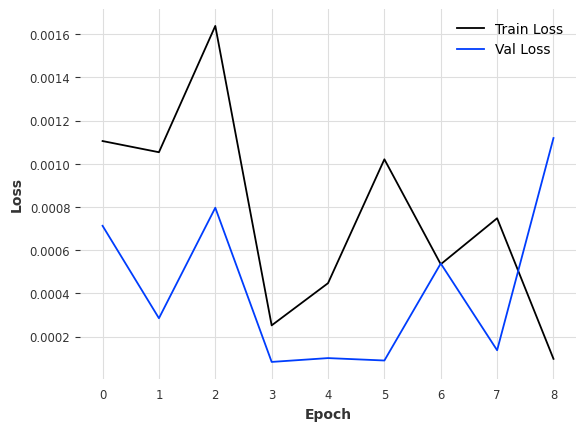

In [28]:
plt.plot(loss_recorder.train_loss_history, label='Train Loss')
plt.plot(loss_recorder.val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [29]:
len(val)

174

In [30]:
val_preds = transformer.inverse_transform(nbeats_model.predict(len(val)))

Predicting: |                                                                                    | 0/? [00:00<…

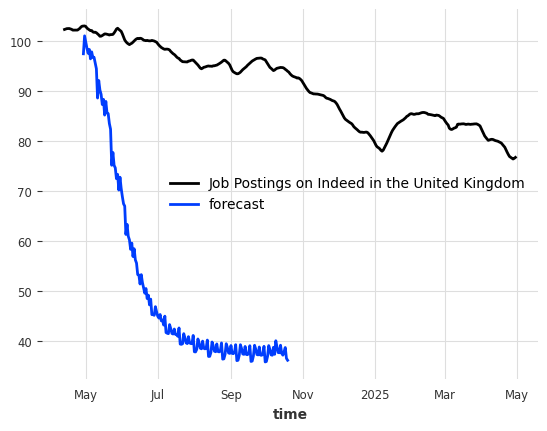

In [31]:
series.drop_before(visualizing).plot()
val_preds.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()
plt.show()

In [32]:
loss_recorder = LossRecorder()
# stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
# a period of 5 epochs (`patience`)
early_stopper = EarlyStopping(
    monitor="val_loss",
    patience=5,
    min_delta=0.00001,
    mode='min',
)

pl_trainer_kwargs={"callbacks": [early_stopper, loss_recorder]}

In [33]:
from darts.models import RNNModel, BlockRNNModel

In [34]:
len(val)

174

In [35]:
lstm_model = RNNModel(
    model="LSTM",
    hidden_dim=20,
    n_rnn_layers=3,
    dropout=0,
    batch_size=64,
    n_epochs=100,
    optimizer_kwargs={"lr": 1e-4},
    model_name="LSTM",
    log_tensorboard=True,
    random_state=7,
    training_length=120,
    input_chunk_length=60,
    # output_chunk_length=12,
    force_reset=True,
    save_checkpoints=True,
    pl_trainer_kwargs=pl_trainer_kwargs,
)


In [36]:
lstm_model.fit(train, val_series=val, verbose=True)


  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 8.6 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
8.6 K     Trainable params
0         Non-trainable params
8.6 K     Total params
0.034     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=3, dropout=0, training_length=120, batch_size=64, n_epochs=100, optimizer_kwargs={'lr': 0.0001}, model_name=LSTM, log_tensorboard=True, random_state=7, input_chunk_length=60, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x000001C77B268EB0>, <__main__.LossRecorder object at 0x000001C77B268A90>]})

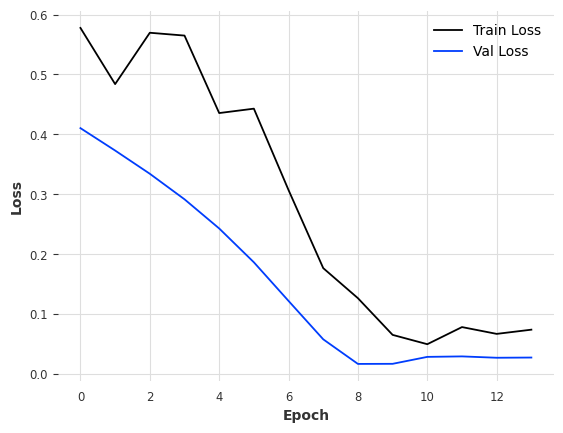

In [37]:
plt.plot(loss_recorder.train_loss_history, label='Train Loss')
plt.plot(loss_recorder.val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [38]:
lstm_model.load_from_checkpoint("LSTM", best=True)

RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=3, dropout=0, training_length=120, batch_size=64, n_epochs=100, optimizer_kwargs={'lr': 0.0001}, model_name=LSTM, log_tensorboard=True, random_state=7, input_chunk_length=60, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x000001C775558AC0>, <__main__.LossRecorder object at 0x000001C775558D90>]})

In [39]:
val_preds = transformer.inverse_transform(lstm_model.predict(len(val)))

Predicting: |                                                                                    | 0/? [00:00<…

In [40]:
lstm_model.first_prediction_index

0

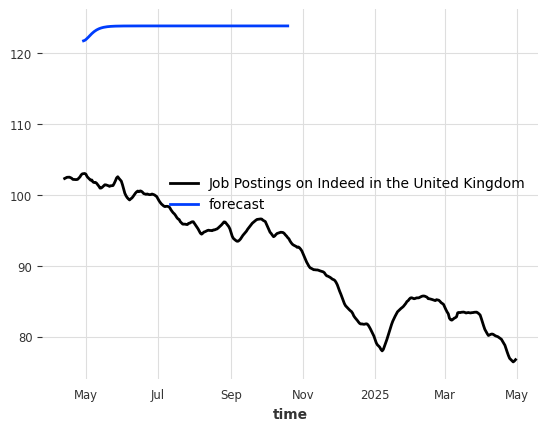

In [41]:
series.drop_before(visualizing).plot()
val_preds.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()
plt.show()

# Backtesting NNs

In [42]:
def backtest_models(series: TimeSeries, models: list, horizons: list=[1, 3, 7], points_to_test: int=100, verbose=True):
    backtest_results = dict()
    for horizon in sorted(horizons):
        backtests = [model.historical_forecasts(
            transformer.transform(series),
            start=len(series) - points_to_test,
            forecast_horizon=horizon,
            retrain=False,
            verbose=verbose,
        ) for model in models]
        backtest_results[horizon] = {str(model.model_name): (backtests[i], mape(transformer.transform(series), backtests[i])) for i, model in enumerate(models)}
    return backtest_results

In [43]:
def plot_backtest_results(series: TimeSeries, backtest_results: dict, points_to_test: int=100):
    for horizon, model in backtest_results.items():
        series.drop_before(len(series) - 2*points_to_test).plot(label='data')
        for model_name, (backtest, mape) in model.items():
            transformer.inverse_transform(backtest).plot(lw=3, label=f'{model_name}, MAPE={mape:.2f}%')
        plt.title(f'Backtests with {horizon} {series.freq} forecast horizon')
        plt.legend()
        plt.show()

In [44]:
models = [nbeats_model, lstm_model]

In [45]:
results = backtest_models(series, models=models)

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

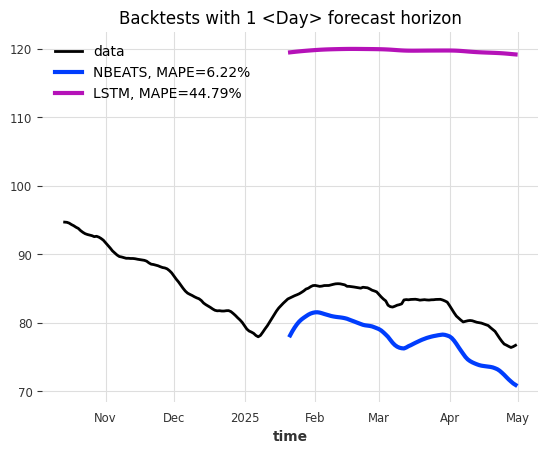

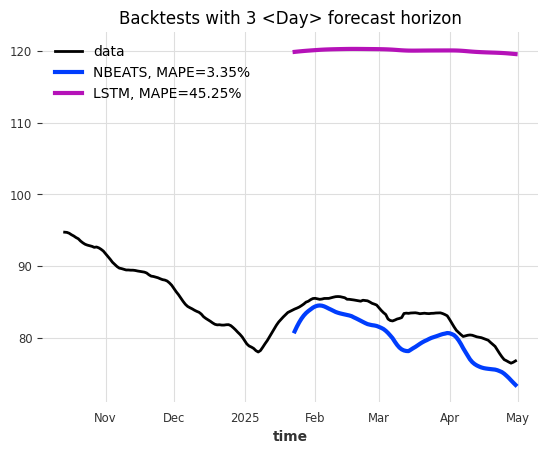

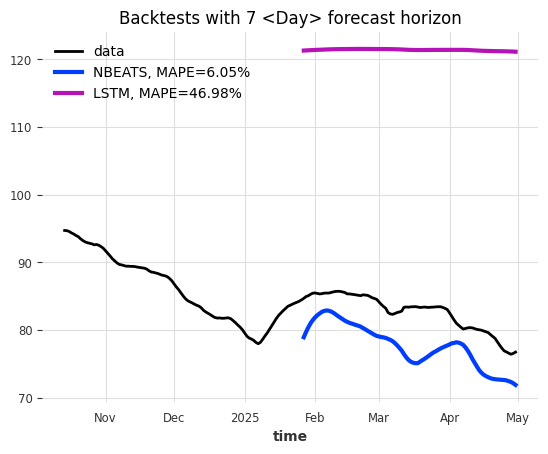

In [46]:
plot_backtest_results(series, results)

In [47]:
import optuna

In [48]:
def train_RNN(params):
    early_stopper = EarlyStopping(
        monitor="val_loss",
        patience=5,
        min_delta=0.05,
        mode='min',
    )
    pl_trainer_kwargs={"callbacks": [early_stopper]}
    
    model = RNNModel(
        **params,
        n_epochs=100,
        model_name=params["model"],
        log_tensorboard=True,
        random_state=7,
        training_length=int(len(val)/2),
        force_reset=True,
        save_checkpoints=True,
        pl_trainer_kwargs=pl_trainer_kwargs,
    )
    model.fit(train, val_series=val, verbose=False)
    model.load_from_checkpoint(params["model"], best=True)
    return model

In [49]:
def optimize_RNN(trial: optuna.Trial):
    params = {
        "model": trial.suggest_categorical("model", ["RNN", "GRU", "LSTM"]),
        "hidden_dim": trial.suggest_int("hidden_dim", 2, 50),
        "n_rnn_layers": trial.suggest_int("n_rnn_layers", 1, 5),
        "dropout": trial.suggest_float("dropout", 0, 0.3),
        "batch_size": trial.suggest_int("batch_size/16", 1, 5) * 16,  # will be multiplied by 16
        "input_chunk_length": trial.suggest_int("input_chunk_length", 1, int(len(val)/4)),
        "optimizer_kwargs": {
            "lr": trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
        }
    }
    if params["n_rnn_layers"] == 1:
        params["dropout"] = 0
    trial.set_user_attr("model_params", params)
    
    model = train_RNN(params)
    
    results = [model_dict[params["model"]][1]/horizon for horizon, model_dict in backtest_models(series, models=[model], horizons=[1, 2, 3, 5, 7]).items()]
    return sum(results) / len(results)
    

In [50]:
# Create optuna study with defined function and storage
study = optuna.create_study(
    direction="minimize",
    storage=storage,
    study_name=f"{series_name}_avg_RNNfamily_study",
    load_if_exists=True
)

[I 2025-05-12 00:31:27,155] A new study created in Journal with name: Job_Postings_avg_RNNfamily_study


In [51]:
# Optimize for n_trials, using one thread, timeout of 5 min
study.optimize(optimize_RNN, n_trials=100, n_jobs=1, timeout=3600)

C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:31:30,676] Trial 0 finished with value: 2.1710448857668725 and parameters: {'model': 'LSTM', 'hidden_dim': 37, 'n_rnn_layers': 1, 'dropout': 0.09341679136033657, 'batch_size/16': 2, 'input_chunk_length': 34, 'learning_rate': 0.0005342838537879844}. Best is trial 0 with value: 2.1710448857668725.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:31:36,335] Trial 1 finished with value: 2.36792739499042 and parameters: {'model': 'RNN', 'hidden_dim': 28, 'n_rnn_layers': 2, 'dropout': 0.18662974892157777, 'batch_size/16': 1, 'input_chunk_length': 10, 'learning_rate': 0.010302433454670306}. Best is trial 0 with value: 2.1710448857668725.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:31:43,486] Trial 2 finished with value: 0.3091371652395173 and parameters: {'model': 'LSTM', 'hidden_dim': 28, 'n_rnn_layers': 5, 'dropout': 0.0341466277222772, 'batch_size/16': 2, 'input_chunk_length': 21, 'learning_rate': 0.0023774838901765576}. Best is trial 2 with value: 0.3091371652395173.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:31:47,448] Trial 3 finished with value: 20.241252108019882 and parameters: {'model': 'GRU', 'hidden_dim': 23, 'n_rnn_layers': 5, 'dropout': 0.10833913588414049, 'batch_size/16': 4, 'input_chunk_length': 30, 'learning_rate': 2.0812092730902418e-05}. Best is trial 2 with value: 0.3091371652395173.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:31:55,004] Trial 4 finished with value: 8.252045526202313 and parameters: {'model': 'LSTM', 'hidden_dim': 38, 'n_rnn_layers': 4, 'dropout': 0.21210590287243536, 'batch_size/16': 2, 'input_chunk_length': 6, 'learning_rate': 6.953905275036835e-05}. Best is trial 2 with value: 0.3091371652395173.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:31:57,045] Trial 5 finished with value: 7.228876498064553 and parameters: {'model': 'LSTM', 'hidden_dim': 8, 'n_rnn_layers': 1, 'dropout': 0.1650080644848023, 'batch_size/16': 5, 'input_chunk_length': 3, 'learning_rate': 0.012997161521633877}. Best is trial 2 with value: 0.3091371652395173.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:32:03,291] Trial 6 finished with value: 2.390172326004297 and parameters: {'model': 'LSTM', 'hidden_dim': 49, 'n_rnn_layers': 4, 'dropout': 0.11293014627940996, 'batch_size/16': 2, 'input_chunk_length': 28, 'learning_rate': 0.0006857117833516267}. Best is trial 2 with value: 0.3091371652395173.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:32:15,052] Trial 7 finished with value: 1.9046195871744118 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 5, 'dropout': 0.04137254364119318, 'batch_size/16': 1, 'input_chunk_length': 5, 'learning_rate': 0.003368885769435432}. Best is trial 2 with value: 0.3091371652395173.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:32:21,494] Trial 8 finished with value: 11.954016583626602 and parameters: {'model': 'RNN', 'hidden_dim': 25, 'n_rnn_layers': 4, 'dropout': 0.1513344720063892, 'batch_size/16': 4, 'input_chunk_length': 10, 'learning_rate': 3.433271240577921e-05}. Best is trial 2 with value: 0.3091371652395173.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:32:36,607] Trial 9 finished with value: 1.1833827931935537 and parameters: {'model': 'GRU', 'hidden_dim': 33, 'n_rnn_layers': 5, 'dropout': 0.07481621907210918, 'batch_size/16': 1, 'input_chunk_length': 23, 'learning_rate': 0.06055968415081008}. Best is trial 2 with value: 0.3091371652395173.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (31) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:32:40,475] Trial 10 finished with value: 18.290541893763397 and parameters: {'model': 'LSTM', 'hidden_dim': 12, 'n_rnn_layers': 3, 'dropout': 0.29326732994439897, 'batch_size/16': 3, 'input_chunk_length': 43, 'learning_rate': 0.08995440814609224}. Best is trial 2 with value: 0.3091371652395173.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:32:52,151] Trial 11 finished with value: 15.07065324091219 and parameters: {'model': 'GRU', 'hidden_dim': 16, 'n_rnn_layers': 5, 'dropout': 0.005659752500487697, 'batch_size/16': 1, 'input_chunk_length': 19, 'learning_rate': 0.0904993016839425}. Best is trial 2 with value: 0.3091371652395173.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:32:57,048] Trial 12 finished with value: 0.4034809418549625 and parameters: {'model': 'GRU', 'hidden_dim': 43, 'n_rnn_layers': 3, 'dropout': 0.04295241323256366, 'batch_size/16': 2, 'input_chunk_length': 19, 'learning_rate': 0.0001730335316835296}. Best is trial 2 with value: 0.3091371652395173.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (31) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:33:00,673] Trial 13 finished with value: 5.67476564184271 and parameters: {'model': 'GRU', 'hidden_dim': 49, 'n_rnn_layers': 3, 'dropout': 0.005919316945915742, 'batch_size/16': 3, 'input_chunk_length': 17, 'learning_rate': 0.00017306444066266492}. Best is trial 2 with value: 0.3091371652395173.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:33:04,343] Trial 14 finished with value: 0.4566486329018212 and parameters: {'model': 'RNN', 'hidden_dim': 43, 'n_rnn_layers': 2, 'dropout': 0.05590116437052391, 'batch_size/16': 2, 'input_chunk_length': 15, 'learning_rate': 0.002355636604011637}. Best is trial 2 with value: 0.3091371652395173.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (31) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:33:08,234] Trial 15 finished with value: 12.278036110802164 and parameters: {'model': 'LSTM', 'hidden_dim': 19, 'n_rnn_layers': 2, 'dropout': 0.03692045108199203, 'batch_size/16': 3, 'input_chunk_length': 24, 'learning_rate': 0.0002109045418265844}. Best is trial 2 with value: 0.3091371652395173.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:33:13,118] Trial 16 finished with value: 0.3777489420949817 and parameters: {'model': 'GRU', 'hidden_dim': 42, 'n_rnn_layers': 3, 'dropout': 0.2489703669781893, 'batch_size/16': 2, 'input_chunk_length': 38, 'learning_rate': 0.001859002731676088}. Best is trial 2 with value: 0.3091371652395173.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:33:16,903] Trial 17 finished with value: 20.38847478513153 and parameters: {'model': 'GRU', 'hidden_dim': 2, 'n_rnn_layers': 4, 'dropout': 0.27078379125776086, 'batch_size/16': 4, 'input_chunk_length': 41, 'learning_rate': 0.0024799854278150894}. Best is trial 2 with value: 0.3091371652395173.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:33:21,245] Trial 18 finished with value: 0.6912561060673721 and parameters: {'model': 'LSTM', 'hidden_dim': 42, 'n_rnn_layers': 2, 'dropout': 0.23733581143426064, 'batch_size/16': 2, 'input_chunk_length': 36, 'learning_rate': 0.008963175042722331}. Best is trial 2 with value: 0.3091371652395173.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (31) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:33:25,394] Trial 19 finished with value: 12.06153119418142 and parameters: {'model': 'RNN', 'hidden_dim': 35, 'n_rnn_layers': 4, 'dropout': 0.2415370782217237, 'batch_size/16': 3, 'input_chunk_length': 27, 'learning_rate': 0.029876082887831182}. Best is trial 2 with value: 0.3091371652395173.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:33:33,645] Trial 20 finished with value: 1.6346931232943724 and parameters: {'model': 'LSTM', 'hidden_dim': 21, 'n_rnn_layers': 3, 'dropout': 0.19560129662737097, 'batch_size/16': 1, 'input_chunk_length': 36, 'learning_rate': 0.0012598633387702475}. Best is trial 2 with value: 0.3091371652395173.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:33:38,398] Trial 21 finished with value: 1.0779186378150147 and parameters: {'model': 'GRU', 'hidden_dim': 43, 'n_rnn_layers': 3, 'dropout': 0.13019469806931597, 'batch_size/16': 2, 'input_chunk_length': 13, 'learning_rate': 0.00020108903784614936}. Best is trial 2 with value: 0.3091371652395173.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:33:43,198] Trial 22 finished with value: 0.3542511253054317 and parameters: {'model': 'GRU', 'hidden_dim': 46, 'n_rnn_layers': 3, 'dropout': 0.07877839205000861, 'batch_size/16': 2, 'input_chunk_length': 20, 'learning_rate': 0.0004481348727977135}. Best is trial 2 with value: 0.3091371652395173.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:33:47,977] Trial 23 finished with value: 0.46508520227283145 and parameters: {'model': 'GRU', 'hidden_dim': 50, 'n_rnn_layers': 3, 'dropout': 0.0765079468552266, 'batch_size/16': 2, 'input_chunk_length': 21, 'learning_rate': 0.0046861248579898995}. Best is trial 2 with value: 0.3091371652395173.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (31) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:33:50,907] Trial 24 finished with value: 0.5455528250608819 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 2, 'dropout': 0.13036540622532986, 'batch_size/16': 3, 'input_chunk_length': 25, 'learning_rate': 0.0012353041751260705}. Best is trial 2 with value: 0.3091371652395173.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:33:56,395] Trial 25 finished with value: 0.4127371336386648 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 4, 'dropout': 0.020914415319765976, 'batch_size/16': 2, 'input_chunk_length': 31, 'learning_rate': 0.0005789182620072954}. Best is trial 2 with value: 0.3091371652395173.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:34:04,336] Trial 26 finished with value: 0.46756922837844517 and parameters: {'model': 'GRU', 'hidden_dim': 47, 'n_rnn_layers': 3, 'dropout': 0.06357799622729975, 'batch_size/16': 1, 'input_chunk_length': 21, 'learning_rate': 0.0004441520200776781}. Best is trial 2 with value: 0.3091371652395173.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (31) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:34:08,860] Trial 27 finished with value: 0.3685275854738109 and parameters: {'model': 'GRU', 'hidden_dim': 46, 'n_rnn_layers': 4, 'dropout': 0.08893906346087442, 'batch_size/16': 3, 'input_chunk_length': 39, 'learning_rate': 0.0017746493733758362}. Best is trial 2 with value: 0.3091371652395173.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:34:12,795] Trial 28 finished with value: 1.4390433287161941 and parameters: {'model': 'RNN', 'hidden_dim': 45, 'n_rnn_layers': 5, 'dropout': 0.09671241165450992, 'batch_size/16': 4, 'input_chunk_length': 32, 'learning_rate': 0.005385578402801514}. Best is trial 2 with value: 0.3091371652395173.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (31) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:34:18,017] Trial 29 finished with value: 6.98259285351035 and parameters: {'model': 'LSTM', 'hidden_dim': 36, 'n_rnn_layers': 4, 'dropout': 0.08644279175797459, 'batch_size/16': 3, 'input_chunk_length': 12, 'learning_rate': 0.00035909264314473195}. Best is trial 2 with value: 0.3091371652395173.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:34:24,979] Trial 30 finished with value: 19.47381923746932 and parameters: {'model': 'LSTM', 'hidden_dim': 39, 'n_rnn_layers': 5, 'dropout': 0.025035663057805038, 'batch_size/16': 5, 'input_chunk_length': 26, 'learning_rate': 5.798128536809686e-05}. Best is trial 2 with value: 0.3091371652395173.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:34:30,905] Trial 31 finished with value: 0.30668199561665344 and parameters: {'model': 'GRU', 'hidden_dim': 46, 'n_rnn_layers': 4, 'dropout': 0.1293275990946324, 'batch_size/16': 2, 'input_chunk_length': 36, 'learning_rate': 0.0015918664812194787}. Best is trial 31 with value: 0.30668199561665344.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:34:36,769] Trial 32 finished with value: 0.3059938492909945 and parameters: {'model': 'GRU', 'hidden_dim': 46, 'n_rnn_layers': 4, 'dropout': 0.12698781743217097, 'batch_size/16': 2, 'input_chunk_length': 40, 'learning_rate': 0.0008850587567586449}. Best is trial 32 with value: 0.3059938492909945.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:34:43,709] Trial 33 finished with value: 0.39838369432776766 and parameters: {'model': 'GRU', 'hidden_dim': 47, 'n_rnn_layers': 5, 'dropout': 0.12167772399904284, 'batch_size/16': 2, 'input_chunk_length': 34, 'learning_rate': 0.0008678994199067458}. Best is trial 32 with value: 0.3059938492909945.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:34:53,518] Trial 34 finished with value: 0.4433304558040782 and parameters: {'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 4, 'dropout': 0.1665277493876349, 'batch_size/16': 1, 'input_chunk_length': 43, 'learning_rate': 0.00042433977194090354}. Best is trial 32 with value: 0.3059938492909945.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:34:56,765] Trial 35 finished with value: 0.2773138611264704 and parameters: {'model': 'GRU', 'hidden_dim': 40, 'n_rnn_layers': 1, 'dropout': 0.15019035090044724, 'batch_size/16': 2, 'input_chunk_length': 29, 'learning_rate': 0.0066009726063967315}. Best is trial 35 with value: 0.2773138611264704.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:35:00,403] Trial 36 finished with value: 0.48429224306662977 and parameters: {'model': 'LSTM', 'hidden_dim': 40, 'n_rnn_layers': 1, 'dropout': 0.17639579262800342, 'batch_size/16': 2, 'input_chunk_length': 29, 'learning_rate': 0.013372313273372335}. Best is trial 35 with value: 0.2773138611264704.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:35:04,808] Trial 37 finished with value: 0.24963356603079262 and parameters: {'model': 'GRU', 'hidden_dim': 34, 'n_rnn_layers': 1, 'dropout': 0.15126972851305015, 'batch_size/16': 1, 'input_chunk_length': 33, 'learning_rate': 0.021337578361827148}. Best is trial 37 with value: 0.24963356603079262.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:35:09,518] Trial 38 finished with value: 0.16974566355881157 and parameters: {'model': 'GRU', 'hidden_dim': 33, 'n_rnn_layers': 1, 'dropout': 0.14984719353621878, 'batch_size/16': 1, 'input_chunk_length': 34, 'learning_rate': 0.022559988011996376}. Best is trial 38 with value: 0.16974566355881157.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:35:14,186] Trial 39 finished with value: 0.2307447767883318 and parameters: {'model': 'GRU', 'hidden_dim': 33, 'n_rnn_layers': 1, 'dropout': 0.15041535242476434, 'batch_size/16': 1, 'input_chunk_length': 32, 'learning_rate': 0.02897411399240595}. Best is trial 38 with value: 0.16974566355881157.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:35:18,456] Trial 40 finished with value: 0.18341137798317653 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'dropout': 0.1522892261989207, 'batch_size/16': 1, 'input_chunk_length': 33, 'learning_rate': 0.02925521809951051}. Best is trial 38 with value: 0.16974566355881157.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:35:23,147] Trial 41 finished with value: 0.16488203212158042 and parameters: {'model': 'GRU', 'hidden_dim': 33, 'n_rnn_layers': 1, 'dropout': 0.14468923680313664, 'batch_size/16': 1, 'input_chunk_length': 33, 'learning_rate': 0.0225015693295308}. Best is trial 41 with value: 0.16488203212158042.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:35:27,832] Trial 42 finished with value: 0.176752637364675 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'dropout': 0.20104104441129508, 'batch_size/16': 1, 'input_chunk_length': 33, 'learning_rate': 0.02593670387899824}. Best is trial 41 with value: 0.16488203212158042.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:35:32,612] Trial 43 finished with value: 0.2690043880384857 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'dropout': 0.20285688033808766, 'batch_size/16': 1, 'input_chunk_length': 31, 'learning_rate': 0.035539761266578734}. Best is trial 41 with value: 0.16488203212158042.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:35:37,442] Trial 44 finished with value: 0.4929569239612716 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'dropout': 0.180718447043418, 'batch_size/16': 1, 'input_chunk_length': 35, 'learning_rate': 0.04866022309248746}. Best is trial 41 with value: 0.16488203212158042.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:35:41,710] Trial 45 finished with value: 0.20655975620668482 and parameters: {'model': 'GRU', 'hidden_dim': 24, 'n_rnn_layers': 1, 'dropout': 0.22197087263284637, 'batch_size/16': 1, 'input_chunk_length': 38, 'learning_rate': 0.017605399365095954}. Best is trial 41 with value: 0.16488203212158042.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:35:45,686] Trial 46 finished with value: 0.23366294765551987 and parameters: {'model': 'RNN', 'hidden_dim': 22, 'n_rnn_layers': 1, 'dropout': 0.20638665692212452, 'batch_size/16': 1, 'input_chunk_length': 38, 'learning_rate': 0.018318297078118075}. Best is trial 41 with value: 0.16488203212158042.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:35:51,715] Trial 47 finished with value: 1.4072347362324176 and parameters: {'model': 'GRU', 'hidden_dim': 24, 'n_rnn_layers': 2, 'dropout': 0.22270108145054998, 'batch_size/16': 1, 'input_chunk_length': 34, 'learning_rate': 0.052712007176925604}. Best is trial 41 with value: 0.16488203212158042.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:35:56,414] Trial 48 finished with value: 0.4312317443695856 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'dropout': 0.16494417211187315, 'batch_size/16': 1, 'input_chunk_length': 37, 'learning_rate': 0.010878430717991492}. Best is trial 41 with value: 0.16488203212158042.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:36:00,655] Trial 49 finished with value: 0.2222731047274981 and parameters: {'model': 'GRU', 'hidden_dim': 26, 'n_rnn_layers': 1, 'dropout': 0.22350775994789748, 'batch_size/16': 1, 'input_chunk_length': 41, 'learning_rate': 0.0183379465959152}. Best is trial 41 with value: 0.16488203212158042.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:36:05,581] Trial 50 finished with value: 0.2980292536349155 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'dropout': 0.19096653570842573, 'batch_size/16': 1, 'input_chunk_length': 28, 'learning_rate': 0.09480786278984878}. Best is trial 41 with value: 0.16488203212158042.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:36:09,950] Trial 51 finished with value: 0.21622471836818322 and parameters: {'model': 'GRU', 'hidden_dim': 26, 'n_rnn_layers': 1, 'dropout': 0.21777332967544435, 'batch_size/16': 1, 'input_chunk_length': 41, 'learning_rate': 0.01664933062905356}. Best is trial 41 with value: 0.16488203212158042.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:36:16,231] Trial 52 finished with value: 0.2707034174670238 and parameters: {'model': 'GRU', 'hidden_dim': 33, 'n_rnn_layers': 2, 'dropout': 0.26079644486159337, 'batch_size/16': 1, 'input_chunk_length': 40, 'learning_rate': 0.041311359450576936}. Best is trial 41 with value: 0.16488203212158042.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:36:20,830] Trial 53 finished with value: 0.4014613430471403 and parameters: {'model': 'GRU', 'hidden_dim': 20, 'n_rnn_layers': 1, 'dropout': 0.22005329114826044, 'batch_size/16': 1, 'input_chunk_length': 42, 'learning_rate': 0.02404246839227577}. Best is trial 41 with value: 0.16488203212158042.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:36:25,103] Trial 54 finished with value: 0.3446600091003382 and parameters: {'model': 'GRU', 'hidden_dim': 17, 'n_rnn_layers': 1, 'dropout': 0.1086579397192211, 'batch_size/16': 1, 'input_chunk_length': 38, 'learning_rate': 0.014659206468256955}. Best is trial 41 with value: 0.16488203212158042.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:36:30,719] Trial 55 finished with value: 1.3975754550094823 and parameters: {'model': 'RNN', 'hidden_dim': 24, 'n_rnn_layers': 2, 'dropout': 0.16747587907649644, 'batch_size/16': 1, 'input_chunk_length': 34, 'learning_rate': 0.007691086703058297}. Best is trial 41 with value: 0.16488203212158042.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:36:35,453] Trial 56 finished with value: 0.24955278771728925 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'dropout': 0.1414625439019702, 'batch_size/16': 1, 'input_chunk_length': 36, 'learning_rate': 0.06459745716572007}. Best is trial 41 with value: 0.16488203212158042.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:36:40,226] Trial 57 finished with value: 0.3183022305212685 and parameters: {'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'dropout': 0.28409085586845295, 'batch_size/16': 1, 'input_chunk_length': 30, 'learning_rate': 0.003360578860397357}. Best is trial 41 with value: 0.16488203212158042.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:36:54,611] Trial 58 finished with value: 9.819192270244084 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 2, 'dropout': 0.24006356405629004, 'batch_size/16': 1, 'input_chunk_length': 39, 'learning_rate': 1.1431941565768041e-05}. Best is trial 41 with value: 0.16488203212158042.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:36:59,339] Trial 59 finished with value: 0.15838246736036926 and parameters: {'model': 'GRU', 'hidden_dim': 35, 'n_rnn_layers': 1, 'dropout': 0.1955818356113714, 'batch_size/16': 1, 'input_chunk_length': 33, 'learning_rate': 0.029539179685768885}. Best is trial 59 with value: 0.15838246736036926.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:37:05,548] Trial 60 finished with value: 0.3199797989429468 and parameters: {'model': 'GRU', 'hidden_dim': 35, 'n_rnn_layers': 2, 'dropout': 0.18294954550174325, 'batch_size/16': 1, 'input_chunk_length': 32, 'learning_rate': 0.07260210394537639}. Best is trial 59 with value: 0.15838246736036926.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:37:09,849] Trial 61 finished with value: 0.3041144218255993 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'dropout': 0.1936800113987741, 'batch_size/16': 1, 'input_chunk_length': 35, 'learning_rate': 0.02775404013191637}. Best is trial 59 with value: 0.15838246736036926.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:37:14,615] Trial 62 finished with value: 0.26284413106049576 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'dropout': 0.2311054697085556, 'batch_size/16': 1, 'input_chunk_length': 30, 'learning_rate': 0.037455175380225046}. Best is trial 59 with value: 0.15838246736036926.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:37:19,466] Trial 63 finished with value: 1.654717157672606 and parameters: {'model': 'GRU', 'hidden_dim': 25, 'n_rnn_layers': 1, 'dropout': 0.2060971461875653, 'batch_size/16': 1, 'input_chunk_length': 2, 'learning_rate': 0.010491955318952025}. Best is trial 59 with value: 0.15838246736036926.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:37:23,694] Trial 64 finished with value: 0.18095548337900996 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'dropout': 0.25528601954663804, 'batch_size/16': 1, 'input_chunk_length': 37, 'learning_rate': 0.016296331793230444}. Best is trial 59 with value: 0.15838246736036926.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:37:27,964] Trial 65 finished with value: 0.1526364990975143 and parameters: {'model': 'RNN', 'hidden_dim': 35, 'n_rnn_layers': 1, 'dropout': 0.25348818752467855, 'batch_size/16': 1, 'input_chunk_length': 33, 'learning_rate': 0.023041221864378784}. Best is trial 65 with value: 0.1526364990975143.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:37:32,207] Trial 66 finished with value: 0.40385355171312315 and parameters: {'model': 'RNN', 'hidden_dim': 35, 'n_rnn_layers': 1, 'dropout': 0.26301097507383503, 'batch_size/16': 1, 'input_chunk_length': 27, 'learning_rate': 0.044476966952879136}. Best is trial 65 with value: 0.1526364990975143.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:37:35,894] Trial 67 finished with value: 0.8618702296105576 and parameters: {'model': 'RNN', 'hidden_dim': 32, 'n_rnn_layers': 2, 'dropout': 0.2531038671835718, 'batch_size/16': 2, 'input_chunk_length': 33, 'learning_rate': 0.023843668180830904}. Best is trial 65 with value: 0.1526364990975143.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:37:39,780] Trial 68 finished with value: 0.21495252878478324 and parameters: {'model': 'RNN', 'hidden_dim': 38, 'n_rnn_layers': 1, 'dropout': 0.2834359861700263, 'batch_size/16': 1, 'input_chunk_length': 23, 'learning_rate': 0.01085068542375184}. Best is trial 65 with value: 0.1526364990975143.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:37:42,615] Trial 69 finished with value: 4.055832116102664 and parameters: {'model': 'RNN', 'hidden_dim': 34, 'n_rnn_layers': 1, 'dropout': 0.14037297241808272, 'batch_size/16': 2, 'input_chunk_length': 7, 'learning_rate': 0.0704834455182229}. Best is trial 65 with value: 0.1526364990975143.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:37:44,766] Trial 70 finished with value: 0.19512203642815643 and parameters: {'model': 'RNN', 'hidden_dim': 30, 'n_rnn_layers': 1, 'dropout': 0.16072967976694916, 'batch_size/16': 4, 'input_chunk_length': 33, 'learning_rate': 0.03428719546602357}. Best is trial 65 with value: 0.1526364990975143.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:37:46,890] Trial 71 finished with value: 1.3507843098808716 and parameters: {'model': 'RNN', 'hidden_dim': 28, 'n_rnn_layers': 1, 'dropout': 0.14146670758852994, 'batch_size/16': 4, 'input_chunk_length': 33, 'learning_rate': 0.03280372792164094}. Best is trial 65 with value: 0.1526364990975143.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:37:50,821] Trial 72 finished with value: 0.3448420886185898 and parameters: {'model': 'RNN', 'hidden_dim': 30, 'n_rnn_layers': 1, 'dropout': 0.15976338062080633, 'batch_size/16': 1, 'input_chunk_length': 31, 'learning_rate': 0.02615388903379505}. Best is trial 65 with value: 0.1526364990975143.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:37:52,892] Trial 73 finished with value: 1.0946293535216505 and parameters: {'model': 'RNN', 'hidden_dim': 36, 'n_rnn_layers': 1, 'dropout': 0.17659363915933604, 'batch_size/16': 5, 'input_chunk_length': 35, 'learning_rate': 0.006347245871428195}. Best is trial 65 with value: 0.1526364990975143.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:37:55,343] Trial 74 finished with value: 9.104022645945786 and parameters: {'model': 'RNN', 'hidden_dim': 32, 'n_rnn_layers': 1, 'dropout': 0.11974438473018999, 'batch_size/16': 4, 'input_chunk_length': 37, 'learning_rate': 0.057727545667291366}. Best is trial 65 with value: 0.1526364990975143.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:37:57,406] Trial 75 finished with value: 0.7260908331215212 and parameters: {'model': 'RNN', 'hidden_dim': 34, 'n_rnn_layers': 1, 'dropout': 0.2990545713613721, 'batch_size/16': 5, 'input_chunk_length': 33, 'learning_rate': 0.013974887370370975}. Best is trial 65 with value: 0.1526364990975143.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:37:59,861] Trial 76 finished with value: 1.4232276300452986 and parameters: {'model': 'LSTM', 'hidden_dim': 30, 'n_rnn_layers': 1, 'dropout': 0.16135242844729605, 'batch_size/16': 4, 'input_chunk_length': 30, 'learning_rate': 0.020401621668010052}. Best is trial 65 with value: 0.1526364990975143.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:38:05,526] Trial 77 finished with value: 0.6225024095908628 and parameters: {'model': 'RNN', 'hidden_dim': 28, 'n_rnn_layers': 2, 'dropout': 0.10253836490509025, 'batch_size/16': 1, 'input_chunk_length': 28, 'learning_rate': 0.008577129125919425}. Best is trial 65 with value: 0.1526364990975143.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:38:11,334] Trial 78 finished with value: 2.6671696607200217 and parameters: {'model': 'GRU', 'hidden_dim': 5, 'n_rnn_layers': 2, 'dropout': 0.1361225072342492, 'batch_size/16': 1, 'input_chunk_length': 34, 'learning_rate': 0.03525874250123454}. Best is trial 65 with value: 0.1526364990975143.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:38:14,558] Trial 79 finished with value: 0.2690709103201424 and parameters: {'model': 'GRU', 'hidden_dim': 41, 'n_rnn_layers': 1, 'dropout': 0.247473171215543, 'batch_size/16': 2, 'input_chunk_length': 32, 'learning_rate': 0.04762824330398148}. Best is trial 65 with value: 0.1526364990975143.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:38:19,427] Trial 80 finished with value: 0.21890781778929153 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'dropout': 0.1562254945744711, 'batch_size/16': 1, 'input_chunk_length': 25, 'learning_rate': 0.0037486875083084757}. Best is trial 65 with value: 0.1526364990975143.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:38:24,178] Trial 81 finished with value: 0.1789085327949053 and parameters: {'model': 'GRU', 'hidden_dim': 33, 'n_rnn_layers': 1, 'dropout': 0.23134565667387247, 'batch_size/16': 1, 'input_chunk_length': 37, 'learning_rate': 0.017335501464721004}. Best is trial 65 with value: 0.1526364990975143.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:38:29,107] Trial 82 finished with value: 0.20314387130812234 and parameters: {'model': 'GRU', 'hidden_dim': 33, 'n_rnn_layers': 1, 'dropout': 0.2709399177637375, 'batch_size/16': 1, 'input_chunk_length': 35, 'learning_rate': 0.013558800291131828}. Best is trial 65 with value: 0.1526364990975143.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:38:33,811] Trial 83 finished with value: 0.20647971756960729 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'dropout': 0.23221353330913483, 'batch_size/16': 1, 'input_chunk_length': 37, 'learning_rate': 0.02972287935825611}. Best is trial 65 with value: 0.1526364990975143.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:38:38,160] Trial 84 finished with value: 0.5138299240745179 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'dropout': 0.20051154120955278, 'batch_size/16': 1, 'input_chunk_length': 36, 'learning_rate': 0.02027789033529398}. Best is trial 65 with value: 0.1526364990975143.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:38:42,882] Trial 85 finished with value: 0.32485582678297614 and parameters: {'model': 'GRU', 'hidden_dim': 34, 'n_rnn_layers': 1, 'dropout': 0.21266912924817502, 'batch_size/16': 1, 'input_chunk_length': 31, 'learning_rate': 0.04055981331335367}. Best is trial 65 with value: 0.1526364990975143.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:38:47,881] Trial 86 finished with value: 0.18661880751843696 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'dropout': 0.18951278139284242, 'batch_size/16': 1, 'input_chunk_length': 39, 'learning_rate': 0.022588841372352456}. Best is trial 65 with value: 0.1526364990975143.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:38:52,265] Trial 87 finished with value: 0.334926196600163 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'dropout': 0.1737900431428166, 'batch_size/16': 1, 'input_chunk_length': 39, 'learning_rate': 0.01570028356780198}. Best is trial 65 with value: 0.1526364990975143.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:38:57,184] Trial 88 finished with value: 0.2572466371941299 and parameters: {'model': 'GRU', 'hidden_dim': 41, 'n_rnn_layers': 1, 'dropout': 0.25383316257054334, 'batch_size/16': 1, 'input_chunk_length': 40, 'learning_rate': 0.011007927929062102}. Best is trial 65 with value: 0.1526364990975143.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:39:01,485] Trial 89 finished with value: 0.32455955464777364 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'dropout': 0.1891403913682401, 'batch_size/16': 1, 'input_chunk_length': 37, 'learning_rate': 0.02208436985479753}. Best is trial 65 with value: 0.1526364990975143.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:39:06,407] Trial 90 finished with value: 0.17983747821615287 and parameters: {'model': 'GRU', 'hidden_dim': 35, 'n_rnn_layers': 1, 'dropout': 0.2308642825884038, 'batch_size/16': 1, 'input_chunk_length': 42, 'learning_rate': 0.07800404244717259}. Best is trial 65 with value: 0.1526364990975143.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:39:11,514] Trial 91 finished with value: 0.29197030734571017 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'dropout': 0.23342191160290932, 'batch_size/16': 1, 'input_chunk_length': 42, 'learning_rate': 0.05645402240687691}. Best is trial 65 with value: 0.1526364990975143.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:39:15,825] Trial 92 finished with value: 0.6042196210477145 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'dropout': 0.242208703027747, 'batch_size/16': 1, 'input_chunk_length': 42, 'learning_rate': 0.076369208528781}. Best is trial 65 with value: 0.1526364990975143.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:39:20,628] Trial 93 finished with value: 0.381888481599684 and parameters: {'model': 'GRU', 'hidden_dim': 35, 'n_rnn_layers': 1, 'dropout': 0.21426998272180076, 'batch_size/16': 1, 'input_chunk_length': 39, 'learning_rate': 0.024558626452444818}. Best is trial 65 with value: 0.1526364990975143.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:39:25,422] Trial 94 finished with value: 0.17829675142270748 and parameters: {'model': 'GRU', 'hidden_dim': 33, 'n_rnn_layers': 1, 'dropout': 0.2275837669426188, 'batch_size/16': 1, 'input_chunk_length': 35, 'learning_rate': 0.017428257506037003}. Best is trial 65 with value: 0.1526364990975143.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:39:30,424] Trial 95 finished with value: 0.3924475357468877 and parameters: {'model': 'GRU', 'hidden_dim': 33, 'n_rnn_layers': 1, 'dropout': 0.2474648549971008, 'batch_size/16': 1, 'input_chunk_length': 34, 'learning_rate': 0.09513374178281071}. Best is trial 65 with value: 0.1526364990975143.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:39:35,356] Trial 96 finished with value: 0.37413747560223637 and parameters: {'model': 'LSTM', 'hidden_dim': 27, 'n_rnn_layers': 1, 'dropout': 0.27213014031193683, 'batch_size/16': 1, 'input_chunk_length': 36, 'learning_rate': 0.007686286458173214}. Best is trial 65 with value: 0.1526364990975143.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:39:40,411] Trial 97 finished with value: 0.27185944620747515 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'dropout': 0.25857200309903733, 'batch_size/16': 1, 'input_chunk_length': 29, 'learning_rate': 0.013141248924053436}. Best is trial 65 with value: 0.1526364990975143.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:39:45,572] Trial 98 finished with value: 0.2762871758319905 and parameters: {'model': 'GRU', 'hidden_dim': 35, 'n_rnn_layers': 1, 'dropout': 0.23048466848791524, 'batch_size/16': 1, 'input_chunk_length': 35, 'learning_rate': 0.016487777331851278}. Best is trial 65 with value: 0.1526364990975143.


Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-12 00:39:51,915] Trial 99 finished with value: 0.8419383701114098 and parameters: {'model': 'GRU', 'hidden_dim': 33, 'n_rnn_layers': 2, 'dropout': 0.28146946176922216, 'batch_size/16': 1, 'input_chunk_length': 32, 'learning_rate': 0.04689963612963065}. Best is trial 65 with value: 0.1526364990975143.


In [52]:
study.best_trial

FrozenTrial(number=65, state=TrialState.COMPLETE, values=[0.1526364990975143], datetime_start=datetime.datetime(2025, 5, 12, 0, 37, 23, 695754), datetime_complete=datetime.datetime(2025, 5, 12, 0, 37, 27, 956289), params={'model': 'RNN', 'hidden_dim': 35, 'n_rnn_layers': 1, 'dropout': 0.25348818752467855, 'batch_size/16': 1, 'input_chunk_length': 33, 'learning_rate': 0.023041221864378784}, user_attrs={'model_params': {'model': 'RNN', 'hidden_dim': 35, 'n_rnn_layers': 1, 'dropout': 0, 'batch_size': 16, 'input_chunk_length': 33, 'optimizer_kwargs': {'lr': 0.023041221864378784}}}, system_attrs={}, intermediate_values={}, distributions={'model': CategoricalDistribution(choices=('RNN', 'GRU', 'LSTM')), 'hidden_dim': IntDistribution(high=50, log=False, low=2, step=1), 'n_rnn_layers': IntDistribution(high=5, log=False, low=1, step=1), 'dropout': FloatDistribution(high=0.3, log=False, low=0.0, step=None), 'batch_size/16': IntDistribution(high=5, log=False, low=1, step=1), 'input_chunk_length':

In [53]:
best_model = train_RNN(study.best_trial.user_attrs["model_params"])

In [54]:
results = backtest_models(series, models=[best_model], horizons=[1, 2, 3, 5, 7, 15, 30])

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

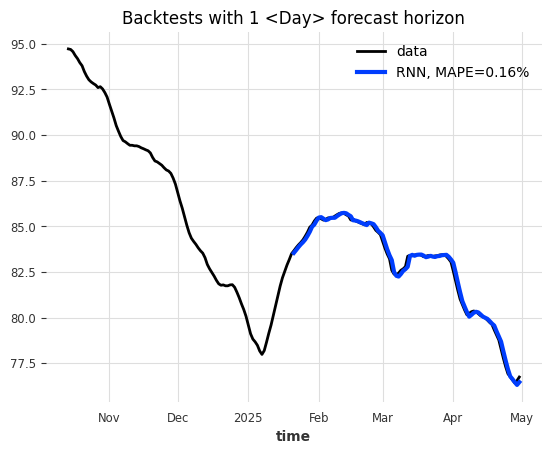

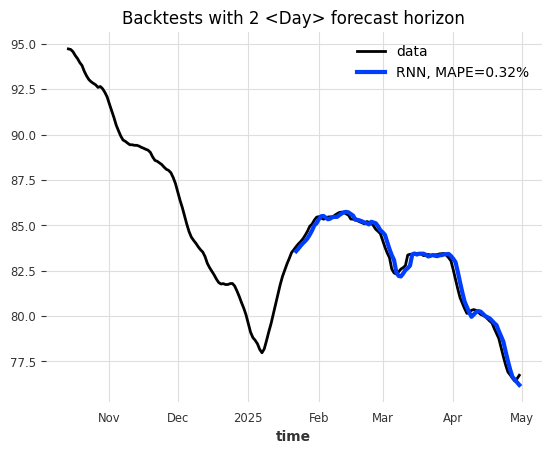

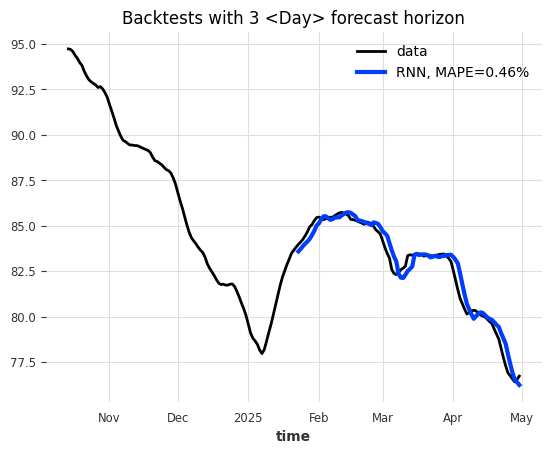

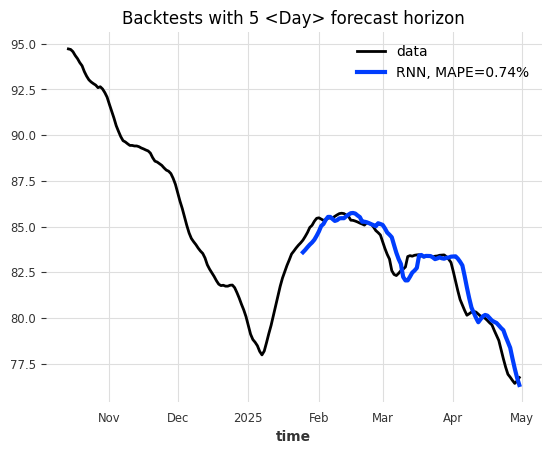

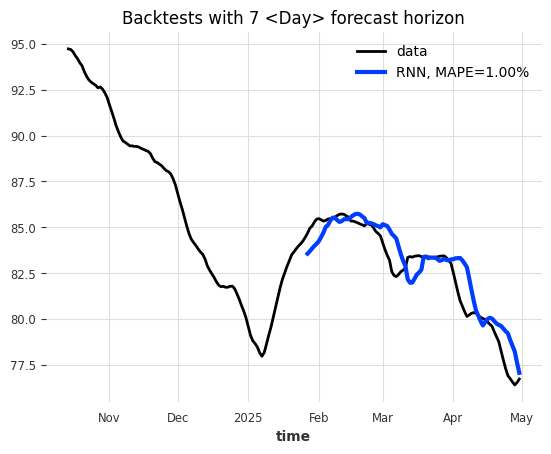

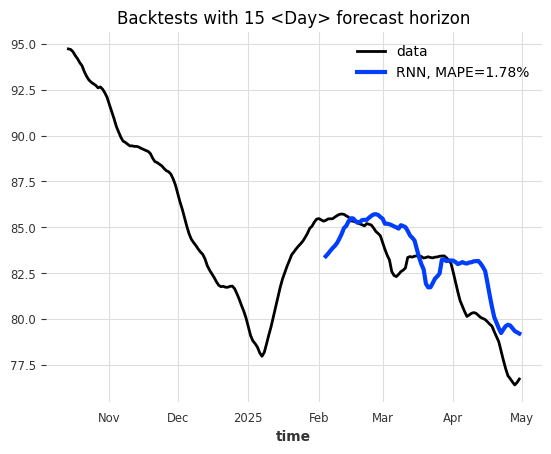

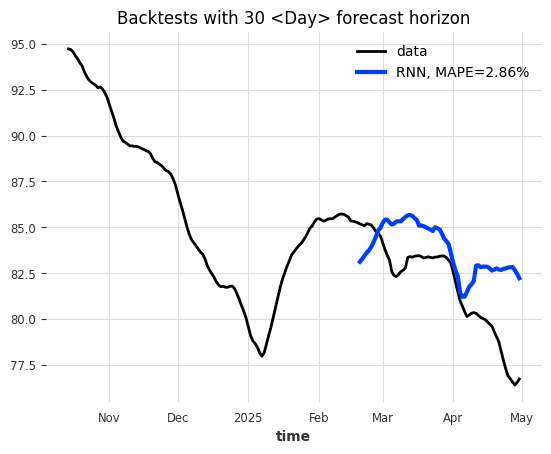

In [55]:
plot_backtest_results(series, results)